## PCA e Árvore de Decisão para Trading (PY) - Classificação do EUR/USD

 

#### Etapas



- Passo 1 - Carregar as bibliotecas

- Passo 2 - Carregar a base de dados

- Passo 3 - Tratamento dos dados

- Passo 4 - Construçao dos alvos

- Passo 5 - Construçao das Variaveis

- Passo 6 - Preparaçao da base para treinamento e teste e aplicando a PCA

- Passo 7 - Treinamento do Modelo sem PCA

- Passo 8 - Avaliaçao dos Resultados

- Passo 9 - Treinamento do Modelo com PCA

- Passo 10 - Avaliaçao dos Modelos

- Passo 11 - Como usar o modelo na pratica

 

________________________________________________________



### Passo 1 - Carregando as bibliotecas

In [411]:
# Carregando as bibliotecas

import matplotlib.pyplot as plt 
from sklearn import datasets
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
import pandas as pd
import numpy as np
get_ipython().run_line_magic('matplotlib', 'inline') 

------

### Passo 2 - carregando a base

In [412]:
# Carregando a base de dados e fazendo os checks iniciais

# Muda o diretorio de trabalho
import os
os.chdir("E:\\Base de dados")

df1 = pd.read_csv("EURUSDdata1.csv", sep = ",")

df1.shape[0]

12815

In [413]:
df1.head()


,1971.01.04,00:00,0.53690,0.53690.1,0.53690.2,0.53690.3,1
0,1971.01.05,00:00,0.5366,0.5366,0.5366,0.5366,1
1,1971.01.06,00:00,0.5365,0.5365,0.5365,0.5365,1
2,1971.01.07,00:00,0.5368,0.5368,0.5368,0.5368,1
3,1971.01.08,00:00,0.5371,0.5371,0.5371,0.5371,1
4,1971.01.11,00:00,0.5371,0.5371,0.5371,0.5371,1


----

### Passo 3 - Tratamento dos dados


In [414]:
df1 = df1.rename(columns = {"1971.01.04" : "Data", "00:00" : "hora",  "0.53690" : "open", "0.53690.1" : "high", "0.53690.2" : "low", "0.53690.3" : "close", "1" :  "volume"})

# Ajustando a data - precisamos transforma-la nos indices do data frame

df1["Data"] = pd.to_datetime(df1["Data"]).dt.normalize()

df1 = df1.set_index("Data")



In [415]:
df1.drop(["volume"], axis = 1, inplace = True)
df1.head()

,hora,open,high,low,close
Data,,,,,
1971-01-05,00:00,0.5366,0.5366,0.5366,0.5366
1971-01-06,00:00,0.5365,0.5365,0.5365,0.5365
1971-01-07,00:00,0.5368,0.5368,0.5368,0.5368
1971-01-08,00:00,0.5371,0.5371,0.5371,0.5371
1971-01-11,00:00,0.5371,0.5371,0.5371,0.5371


-------------

### Passo 4 - contrução dos alvos


In [416]:
# Construção dos alvos

periodos = 5 

# Alvo 1 - Retorno
df1["Retorno"] = df1["close"].pct_change(periodos)
df1["Alvo1"] = df1["Retorno"].shift(-periodos)

# Variação em Pips do alvo
df1["Pips"] = (df1["close"] - df1["close"].shift(1))*10000
df1["Pips"] = df1["Pips"].shift(-periodos)

# Criação do alvo
df1["Alvo_Bin"] = np.where(df1['Alvo1'] > 0, 1, 0)

In [417]:
# Analisando a proporçao dos alvos categoricos

df1["Alvo_Bin"].value_counts(normalize=True)*100

1    50.67499
0    49.32501
Name: Alvo_Bin, dtype: float64

----------


### Passo 5 - Construção de variaveis

In [418]:
# Construçao das Variaveis

# Desvio Padrao de 5 dias
df1["std5"] = df1["close"].rolling(5).std()

# Desvio Padrao de 10 dias
df1["std10"] = df1["close"].rolling(10).std()

# Desvio Padrao de 15 dias
df1["std15"] = df1["close"].rolling(15).std()

# Proporçao do corpo do candle em relacao ao range do dia
df1["prop"] = (df1["close"]-df1["open"])/(df1["high"]-df1["low"])

# Direçao do dia atual
df1["dir_D"] = np.where(df1["close"] > df1["open"] , "1", "0")

# Direçao D-1
df1["dir_D1"] = df1["dir_D"].shift(1)

# Direçao D-2
df1["dir_D2"] = df1["dir_D"].shift(2)

# Direçao D-3
df1["dir_D3"] = df1["dir_D"].shift(3)

# Media Movel de 15 dias std5
df1["mm_std5"] = df1["std5"].rolling(15).mean()

# Media Movel de 15 dias std5
df1["mm_std10"] = df1["std10"].rolling(15).mean()

# Media Movel de 15 dias std5
df1["mm_std15"] = df1["std15"].rolling(15).mean()

# RSL std5
df1["RSL_std5"] = (df1["std5"]/df1["std5"].rolling(15).mean())-1

# RSL std10
df1["RSL_std10"] = (df1["std10"]/df1["std10"].rolling(15).mean())-1

# RSL std15
df1["RSL_std15"] = (df1["std15"]/df1["std15"].rolling(15).mean())-1

# Media Movel de 15 dias
df1["mm"] = df1["close"].rolling(15).mean()

# Zscore
df1["zscore"] = (df1["close"]-df1["mm"])/df1["std15"]

# RSL
df1["RSL"] = (df1["close"]/df1["mm"])-1

# Aplicando a fisica

p = 5 

# Velocidade de p dias
df1["v"] = (df1["Retorno"] - df1["Retorno"].shift(p))/p

# Aceleraçao de p dias
df1["a"] = (df1["v"] - df1["v"].shift(p))/p

# Força
# Calculando a massa
df1["m"] = df1["Retorno"].rolling(p).sum()
df1["f"] = df1["m"]*df1["a"]

# Energia cinética
df1["T"] = 0.5*df1["m"]*df1["v"]*df1["v"]

# Trabalho 
# cateto_oposto
cat_op = df1["Retorno"].rolling(p).sum()-df1["Retorno"].rolling(1).sum()
cat_ad = p
df1["cat"] = cat_op/cat_ad
df1 = df1.dropna(axis = 0)
df1["w"] = df1["f"]*np.cos(np.arctan(df1["cat"]))

# Energia potencial
df1["k"] = cat_op*df1["m"]

# Torque
df1["tau"] = df1["f"]*np.sin(np.arctan(df1["cat"]))

# Momentum
df1["M"] = df1["m"]*df1["v"]

# Gravidade
df1["g"] = df1["m"]*df1["Retorno"].rolling(p).sum()/(df1["m"]/df1["Retorno"].rolling(p).sum())*(df1["m"]/df1["Retorno"].rolling(p).sum())

In [419]:
df1.head()

,hora,open,high,low,close,Retorno,Alvo1,Pips,Alvo_Bin,std5,...,a,m,f,T,cat,w,k,tau,M,g
Data,,,,,,,,,,,,,,,,,,,,,
1972-05-23,00:00,0.6154,0.6154,0.6151,0.6153,0.002281,0.000650,-2.0,1,0.000228,...,0.000481,-0.001289,-6.199431e-07,-8.825004e-10,-0.000714,-6.199429e-07,0.000005,4.425479e-10,-1.508200e-06,NaN
1972-06-01,00:00,0.6155,0.6158,0.6155,0.6158,0.000325,0.000487,3.0,1,0.000492,...,-0.000169,0.002601,-4.394770e-07,3.443157e-11,0.000455,-4.394770e-07,0.000006,-2.000918e-10,-4.232470e-07,NaN
1972-06-05,00:00,0.6155,0.6155,0.6154,0.6155,0.000325,0.003412,13.0,1,0.000179,...,-0.000104,0.003902,-4.061682e-07,3.307821e-11,0.000715,-4.061681e-07,0.000014,-2.905747e-10,-5.080816e-07,NaN
1972-06-06,00:00,0.6156,0.6157,0.6155,0.6156,-0.000487,0.004548,8.0,1,0.000130,...,-0.000084,0.002114,-1.786133e-07,1.351445e-10,0.000520,-1.786133e-07,0.000006,-9.293137e-11,-7.559713e-07,NaN
1972-06-08,00:00,0.6159,0.6161,0.6159,0.6161,0.000487,0.003733,6.0,1,0.000255,...,0.000039,0.001789,6.982744e-08,9.423095e-13,0.000260,6.982744e-08,0.000002,1.818051e-11,5.806515e-08,0.000005


In [420]:
df1_filtrado = df1.dropna(axis = 0)

In [421]:
df1_filtrado.head()

,hora,open,high,low,close,Retorno,Alvo1,Pips,Alvo_Bin,std5,...,a,m,f,T,cat,w,k,tau,M,g
Data,,,,,,,,,,,,,,,,,,,,,
1972-06-08,00:00,0.6159,0.6161,0.6159,0.6161,0.000487,0.003733,6.0,1,0.000255,...,0.000039,0.001789,6.982744e-08,9.423095e-13,0.000260,6.982744e-08,2.328936e-06,1.818051e-11,5.806515e-08,0.000005
1972-06-09,00:00,0.6162,0.6165,0.6162,0.6163,0.001300,0.001623,-11.0,1,0.000336,...,-0.000078,0.001787,-1.396551e-07,1.022831e-16,0.000098,-1.396551e-07,8.713797e-07,-1.361750e-11,-6.046658e-10,0.000003
1972-06-12,00:00,0.6175,0.6179,0.6174,0.6176,0.003412,-0.001619,-7.0,0,0.000785,...,0.000150,0.004874,7.287494e-07,9.288528e-10,0.000292,7.287493e-07,7.127181e-06,2.131231e-10,3.009097e-06,0.000025
1972-06-13,00:00,0.6184,0.6186,0.6184,0.6184,0.004548,-0.004366,-9.0,0,0.001110,...,0.000273,0.009910,2.704608e-06,5.025415e-09,0.001072,2.704607e-06,5.312746e-05,2.899990e-09,9.979971e-06,0.000092
1972-06-14,00:00,0.6178,0.6178,0.6177,0.6178,0.003248,-0.004694,-8.0,0,0.000996,...,0.000143,0.012995,1.857279e-06,2.474154e-09,0.001949,1.857275e-06,1.266648e-04,3.620645e-09,8.018933e-06,0.000169


### Features

In [422]:
corte = 10
df1_filtrado["RSL"] = pd.qcut(df1_filtrado["RSL"], corte, labels = False)
df1_filtrado["zscore"] = pd.qcut(df1_filtrado["zscore"], corte, labels = False)
#df1_filtrado["dir_D3"] = pd.qcut(df1_filtrado["dir_D-3"], corte, labels = False)
#df1_filtrado["dir_D2"] = pd.qcut(df1_filtrado["dir_D-2"], corte, labels = False)
#df1_filtrado["dir_D1"] = pd.qcut(df1_filtrado["dir-D-1"], corte, labels = False)
#df1_filtrado["dir_D"] = pd.qcut(df1_filtrado["dir_D"], corte, labels = False)
#df1_filtrado["prop"] = pd.qcut(df1_filtrado["prop"], corte, labels = False)
df1_filtrado["mm"] = pd.qcut(df1_filtrado["mm"], corte, labels = False)
df1_filtrado["RSL_std5"] = pd.qcut(df1_filtrado["RSL_std5"], corte, labels = False)
df1_filtrado["RSL_std10"] = pd.qcut(df1_filtrado["RSL_std10"], corte, labels = False)
df1_filtrado["RSL_std15"] = pd.qcut(df1_filtrado["RSL_std15"], corte, labels = False)
df1_filtrado["v"] = pd.qcut(df1_filtrado["v"], corte, labels = False)
df1_filtrado["a"] = pd.qcut(df1_filtrado["a"], corte, labels = False)
df1_filtrado["m"] = pd.qcut(df1_filtrado["m"], corte, labels = False)
df1_filtrado["f"] = pd.qcut(df1_filtrado["f"], corte, labels = False)
df1_filtrado["T"] = pd.qcut(df1_filtrado["T"], corte, labels = False)
df1_filtrado["w"] = pd.qcut(df1_filtrado["w"], corte, labels = False)
df1_filtrado["k"] = pd.qcut(df1_filtrado["k"], corte, labels = False)
df1_filtrado["tau"] = pd.qcut(df1_filtrado["tau"], corte, labels = False)
df1_filtrado["M"] = pd.qcut(df1_filtrado["M"], corte, labels = False)
df1_filtrado["g"] = pd.qcut(df1_filtrado["g"], corte, labels = False)

<ipython-input-422-e69c51721ee8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_filtrado["RSL"] = pd.qcut(df1_filtrado["RSL"], corte, labels = False)
<ipython-input-422-e69c51721ee8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_filtrado["zscore"] = pd.qcut(df1_filtrado["zscore"], corte, labels = False)
<ipython-input-422-e69c51721ee8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [423]:
pd.crosstab(pd.qcut(df1_filtrado["zscore"], corte, labels = False), df1_filtrado["Alvo_Bin"])/df1.shape[0]*100

Alvo_Bin,0,1
zscore,,
0,5.543836,4.455320
1,5.316007,4.683149
2,5.138807,4.851911
3,5.113493,4.885664
4,5.045988,4.953169
5,4.514387,5.476331
6,5.054426,4.944730
7,4.514387,5.476331
8,4.624082,5.375074


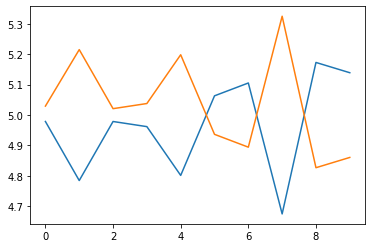

In [424]:
# Queremos um grafico ascendente ou descendente
plt.plot(pd.crosstab(pd.qcut(df1["tau"], corte, labels = False), df1["Alvo_Bin"])/df1.shape[0]*100);

In [425]:
df1_filtrado.tail()

,hora,open,high,low,close,Retorno,Alvo1,Pips,Alvo_Bin,std5,...,a,m,f,T,cat,w,k,tau,M,g
Data,,,,,,,,,,,,,,,,,,,,,
2022-01-05,00:00,1.12852,1.13466,1.12765,1.13135,-0.003014,0.011279,74.5,1,0.003809,...,4,4,5,4,0.000219,5,0,5,4,0
2022-01-06,00:00,1.13111,1.13316,1.12846,1.12976,-0.002472,0.013835,12.8,1,0.003933,...,4,4,5,4,-0.000371,5,0,4,4,0
2022-01-07,00:00,1.12960,1.13647,1.12901,1.13590,-0.002179,0.004992,-38.2,1,0.002871,...,4,3,5,3,-0.001998,5,2,4,5,1
2022-01-10,00:00,1.13550,1.13599,1.12853,1.13252,0.002487,-0.000318,-94.1,0,0.002813,...,6,4,4,4,-0.001917,4,1,5,3,1
2022-01-11,00:00,1.13230,1.13753,1.13131,1.13666,0.007124,-0.002279,19.1,0,0.002957,...,6,5,5,5,-0.001035,5,0,4,4,0


--------

### Passo 6 - Treinamento e teste aplicando a PCA

In [426]:
df1_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11847 entries, 1972-06-08 to 2022-01-11
Data columns (total 37 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hora       11847 non-null  object 
 1   open       11847 non-null  float64
 2   high       11847 non-null  float64
 3   low        11847 non-null  float64
 4   close      11847 non-null  float64
 5   Retorno    11847 non-null  float64
 6   Alvo1      11847 non-null  float64
 7   Pips       11847 non-null  float64
 8   Alvo_Bin   11847 non-null  int32  
 9   std5       11847 non-null  float64
 10  std10      11847 non-null  float64
 11  std15      11847 non-null  float64
 12  prop       11847 non-null  float64
 13  dir_D      11847 non-null  object 
 14  dir_D1     11847 non-null  object 
 15  dir_D2     11847 non-null  object 
 16  dir_D3     11847 non-null  object 
 17  mm_std5    11847 non-null  float64
 18  mm_std10   11847 non-null  float64
 19  mm_std15   11847 non-null  fl

In [427]:
# Separando os dados entre treinamento e teste

# Nossa base vai de 30-09-2009 a 24-10-2019

# Vamos treinar o modelo de 2009 a 2013
start_train = "1972-08-10"
end_train = "1997-12-31"

# Vamos testar o modelo de 2014 a 2019
start_test = "1998-01-01"
end_test = "2022-01-11"

df1_train1 = df1_filtrado.loc[start_train : end_train]

df1_test1 = df1_filtrado.loc[start_test : end_test]

In [428]:
print(df1_train1.shape)

print(df1_test1.shape)

(5586, 37)
(6233, 37)


In [429]:
df1.columns[9:]

Index(['std5', 'std10', 'std15', 'prop', 'dir_D', 'dir_D1', 'dir_D2', 'dir_D3',
       'mm_std5', 'mm_std10', 'mm_std15', 'RSL_std5', 'RSL_std10', 'RSL_std15',
       'mm', 'zscore', 'RSL', 'v', 'a', 'm', 'f', 'T', 'cat', 'w', 'k', 'tau',
       'M', 'g'],
      dtype='object')

In [430]:
# Separando os dados com as variaveis em x e o alvo em y
 
x_train1 = df1_train1.iloc[:, 9:df1.shape[1]]
y_train1 = df1_train1['Alvo_Bin']

x_test1 = df1_test1.iloc[:, 9:df1.shape[1]]
y_test1 = df1_test1['Alvo_Bin']

In [431]:
# Padronaziçao a base 

sc = StandardScaler()

x_train1_pca = sc.fit_transform(x_train1)
x_test1_pca = sc.transform(x_test1)

In [432]:
# Aplicando a PCA

pca = PCA(n_components = 10)
pcas = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"]

x_train1_pca = pca.fit_transform(x_train1_pca)
x_test1_pca = pca.transform(x_test1_pca)

In [433]:
explained_variance = pca.explained_variance_ratio_

sum(explained_variance)

0.8773528267320736

---------

### Passo 7 - Treinamentro do modelo com PCA

In [434]:
# Treinamento da arvore de decisao para a tarefa de classificaçao - reveja a aula de tarefas de data mining se preciso

from sklearn.tree import DecisionTreeClassifier

mod_arvore_pca = DecisionTreeClassifier(criterion = "gini", max_depth = 20
                                        , min_samples_leaf = 60
                                        , min_samples_split = 20
                                        , max_leaf_nodes = 20)

mod_arvore_pca.fit(x_train1_pca, y_train1) # essa é a linha que treina o modelo!!!!

DecisionTreeClassifier(max_depth=20, max_leaf_nodes=20, min_samples_leaf=60,
                       min_samples_split=20)

In [435]:
# Prediçoes para o teste

y_pred_test1_pca = mod_arvore_pca.predict(x_test1_pca)

In [436]:
# Como availar os resultados?

print(confusion_matrix(y_test1, y_pred_test1_pca))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_test1, y_pred_test1_pca))

[[1623 1466]
 [1625 1519]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.50      0.53      0.51      3089
           1       0.51      0.48      0.50      3144

    accuracy                           0.50      6233
   macro avg       0.50      0.50      0.50      6233
weighted avg       0.50      0.50      0.50      6233



In [437]:
# Acuràcia do modelo

print("Acuracia com PCA:", round(metrics.accuracy_score(y_test1, y_pred_test1_pca)*100, 3))

Acuracia com PCA: 50.409


In [438]:
# Calculando a performance com pca

df1_test1.loc[: , "Previsto_PCA"] = y_pred_test1_pca

C:\ProgramData\anaconda\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\ProgramData\anaconda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [439]:
# Ajustando o retorno em pips com o resultado do modelo e subtraind os custos operacionais (1pip)

df1_test1.loc[: , "Ret_Pips_PCA"] = np.where(df1_test1.loc[: , 'Previsto_PCA'] == 1 , df1_test1.loc[: , 'Pips']-1, '0')
df1_test1.loc[: , "Ret_Pips_PCA"] = np.where(df1_test1.loc[: , 'Previsto_PCA'] == 0 , -1*df1_test1.loc[: , 'Pips']-1, df1_test1.loc[: , "Ret_Pips_PCA"])

C:\ProgramData\anaconda\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\ProgramData\anaconda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\ProgramData\anaconda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [440]:
# Convertendo para float

df1_test1.loc[: , "Ret_Pips_PCA"] = df1_test1["Ret_Pips_PCA"].astype(float)

In [441]:
df1_test1.loc[: , "Ret_Pips_PCA_Acumulado"] = df1_test1["Ret_Pips_PCA"].cumsum()

C:\ProgramData\anaconda\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [442]:
df1_test1.loc[: , "Ret_Pips_PCA_Acumulado"].tail()

Data
2022-01-05    753.3
2022-01-06    765.1
2022-01-07    725.9
2022-01-10    630.8
2022-01-11    648.9
Name: Ret_Pips_PCA_Acumulado, dtype: float64

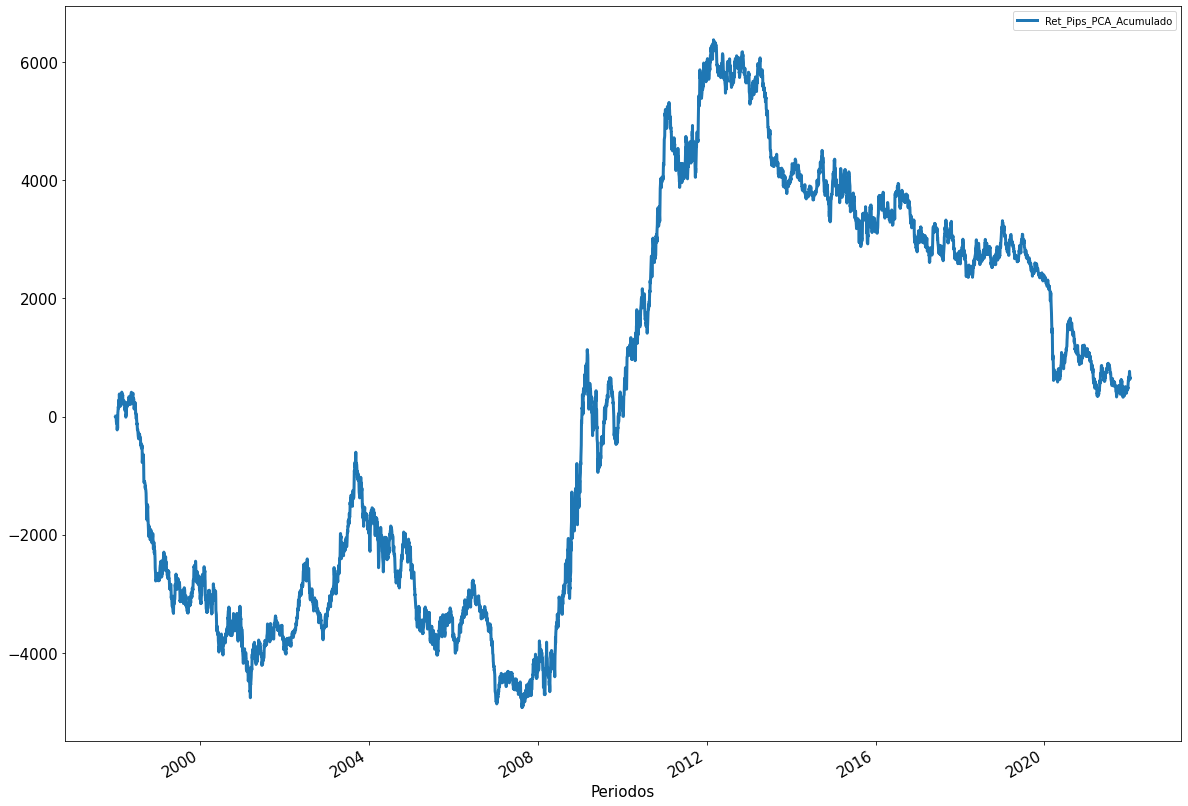

In [443]:
df1_test1["Ret_Pips_PCA_Acumulado"].plot(figsize=(20,15)
                                     , linewidth = 3
                                     , fontsize = 15)
plt.xlabel('Periodos'
           , fontsize = 15);
plt.legend();

------

### Avaliação dos modelos

In [444]:
df1_test1.loc[: , 'Resultado_Aleatorio'] = np.random.randint(0, 2, size = len(df1_test1)).astype(float)

df1_test1.loc[: , "Resultado_Aleatorio"] = np.where(df1_test1.loc[: , 'Resultado_Aleatorio'] == 1 , df1_test1.loc[: , 'Pips'], '0')
df1_test1.loc[: , "Resultado_Aleatorio"] = np.where(df1_test1.loc[: , 'Resultado_Aleatorio'] == 0 , -1*df1_test1.loc[: , 'Pips'], df1_test1.loc[: , "Resultado_Aleatorio"])

df1_test1.loc[: , "Resultado_Aleatorio"] = df1_test1["Resultado_Aleatorio"].astype(float).cumsum()

df1_test1.loc[: , 'Resultado_Aleatorio2'] = np.random.randint(0, 2, size = len(df1_test1)).astype(float)

df1_test1.loc[: , "Resultado_Aleatorio2"] = np.where(df1_test1.loc[: , 'Resultado_Aleatorio2'] == 1 , df1_test1.loc[: , 'Pips'], '0')
df1_test1.loc[: , "Resultado_Aleatorio2"] = np.where(df1_test1.loc[: , 'Resultado_Aleatorio2'] == 0 , -1*df1_test1.loc[: , 'Pips'], df1_test1.loc[: , "Resultado_Aleatorio2"])

df1_test1.loc[: , "Resultado_Aleatorio2"] = df1_test1["Resultado_Aleatorio2"].astype(float).cumsum()

C:\ProgramData\anaconda\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\ProgramData\anaconda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\ProgramData\anaconda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [445]:
df1_test1.loc[: , 'Resultado_Aleatorio'].tail()

Data
2022-01-05   -299.8
2022-01-06   -299.8
2022-01-07   -299.8
2022-01-10   -299.8
2022-01-11   -280.7
Name: Resultado_Aleatorio, dtype: float64

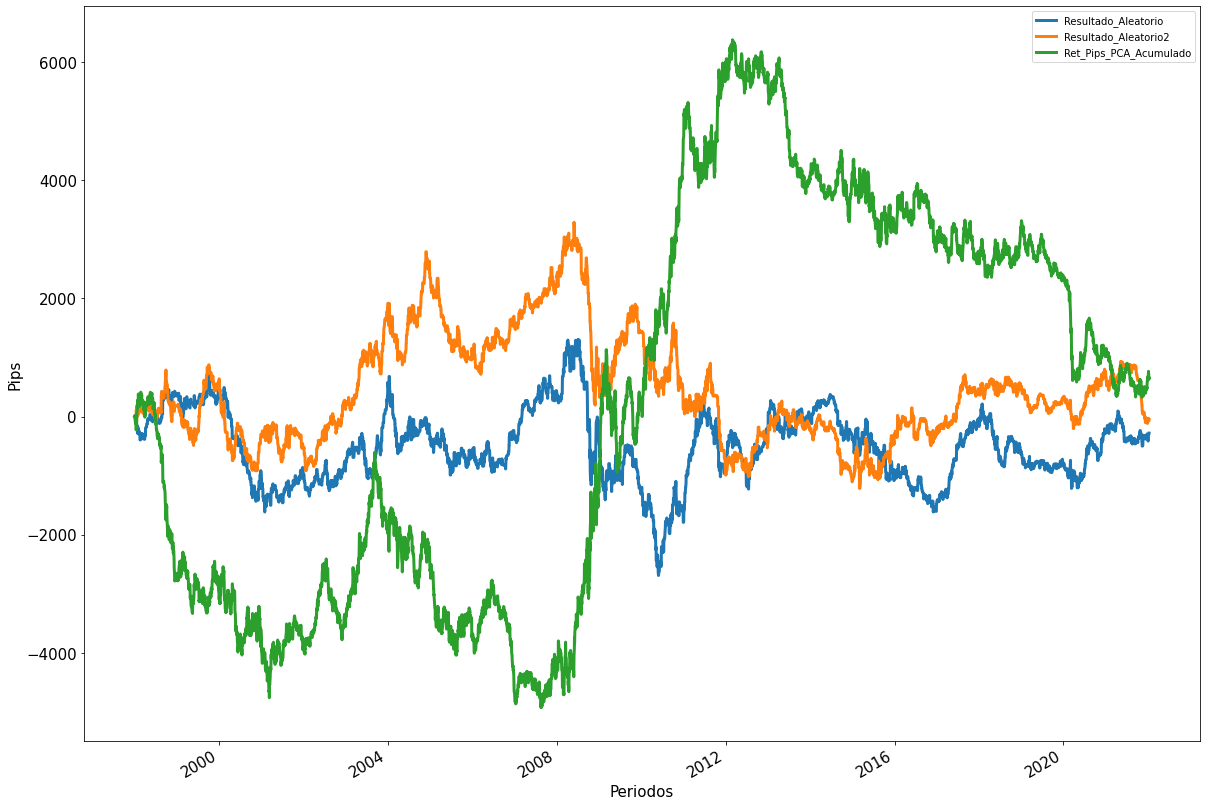

In [446]:
df1_test1["Resultado_Aleatorio"].plot(figsize=(20,15)
                                     , linewidth = 3
                                     , fontsize = 15)
df1_test1["Resultado_Aleatorio2"].plot(figsize=(20,15)
                                     , linewidth = 3
                                     , fontsize = 15)
#df1_test1["Ret_Pips_Sem_PCA_Acumulado"].plot(figsize=(20,15)
                                     #, linewidth = 3
                                     #, fontsize = 15)
df1_test1["Ret_Pips_PCA_Acumulado"].plot(figsize=(20,15)
                                     , linewidth = 3
                                     , fontsize = 15)
plt.xlabel('Periodos'
           , fontsize = 15);
plt.ylabel('Pips'
           , fontsize = 15);
plt.legend()

----


### Modelo na pratica

In [447]:
df1.tail()

,hora,open,high,low,close,Retorno,Alvo1,Pips,Alvo_Bin,std5,...,a,m,f,T,cat,w,k,tau,M,g
Data,,,,,,,,,,,,,,,,,,,,,
2022-01-05,00:00,1.12852,1.13466,1.12765,1.13135,-0.003014,0.011279,74.5,1,0.003809,...,-0.000155,-0.001919,2.977210e-07,-9.393570e-10,0.000219,2.977210e-07,-0.000002,6.520104e-11,0.000002,0.000004
2022-01-06,00:00,1.13111,1.13316,1.12846,1.12976,-0.002472,0.013835,12.8,1,0.003933,...,-0.000106,-0.004329,4.571636e-07,-5.030968e-10,-0.000371,4.571636e-07,0.000008,-1.697925e-10,0.000002,0.000019
2022-01-07,00:00,1.12960,1.13647,1.12901,1.13590,-0.002179,0.004992,-38.2,1,0.002871,...,-0.000246,-0.012171,2.999906e-06,-1.496606e-08,-0.001998,2.999900e-06,0.000122,-5.994995e-09,0.000019,0.000148
2022-01-10,00:00,1.13550,1.13599,1.12853,1.13252,0.002487,-0.000318,-94.1,0,0.002813,...,0.000482,-0.007096,-3.420586e-06,-3.654291e-09,-0.001917,-3.420579e-06,0.000068,6.556326e-09,-0.000007,0.000050
2022-01-11,00:00,1.13230,1.13753,1.13131,1.13666,0.007124,-0.002279,19.1,0,0.002957,...,0.000530,0.001946,1.030828e-06,3.183316e-09,-0.001035,1.030827e-06,-0.000010,-1.067374e-09,0.000004,0.000004


-----------

### Passo 8 - modelo na pratica

In [448]:
# Primeiro, crie uma nova linha com os valores do dia

hoje = pd.Series(
    data = {"open" : 1.13278, "high" : 1.13508, "low" : 1.13188, 'close' : 1.13490}
    , name = "2022-01-19 00:00:00")

# Segundo, adicione essa linha ao dataframe

df1 = df1.append(hoje, ignore_index = False)

df1.tail(3)

,hora,open,high,low,close,Retorno,Alvo1,Pips,Alvo_Bin,std5,...,a,m,f,T,cat,w,k,tau,M,g
Data,,,,,,,,,,,,,,,,,,,,,
2022-01-10 00:00:00,00:00,1.13550,1.13599,1.12853,1.13252,0.002487,-0.000318,-94.1,0.0,0.002813,...,0.000482,-0.007096,-0.000003,-3.654291e-09,-0.001917,-0.000003,0.000068,6.556326e-09,-0.000007,0.000050
2022-01-11 00:00:00,00:00,1.13230,1.13753,1.13131,1.13666,0.007124,-0.002279,19.1,0.0,0.002957,...,0.000530,0.001946,0.000001,3.183316e-09,-0.001035,0.000001,-0.000010,-1.067374e-09,0.000004,0.000004
2022-01-19 00:00:00,NaN,1.13278,1.13508,1.13188,1.13490,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [450]:
df1 = df1.drop(["hora"], axis = 1)

In [451]:
df1.head()

,open,high,low,close,Retorno,Alvo1,Pips,Alvo_Bin,std5,std10,...,a,m,f,T,cat,w,k,tau,M,g
Data,,,,,,,,,,,,,,,,,,,,,
1972-05-23 00:00:00,0.6154,0.6154,0.6151,0.6153,0.002281,0.000650,-2.0,1.0,0.000228,0.000680,...,0.000481,-0.001289,-6.199431e-07,-8.825004e-10,-0.000714,-6.199429e-07,0.000005,4.425479e-10,-1.508200e-06,NaN
1972-06-01 00:00:00,0.6155,0.6158,0.6155,0.6158,0.000325,0.000487,3.0,1.0,0.000492,0.000429,...,-0.000169,0.002601,-4.394770e-07,3.443157e-11,0.000455,-4.394770e-07,0.000006,-2.000918e-10,-4.232470e-07,NaN
1972-06-05 00:00:00,0.6155,0.6155,0.6154,0.6155,0.000325,0.003412,13.0,1.0,0.000179,0.000357,...,-0.000104,0.003902,-4.061682e-07,3.307821e-11,0.000715,-4.061681e-07,0.000014,-2.905747e-10,-5.080816e-07,NaN
1972-06-06 00:00:00,0.6156,0.6157,0.6155,0.6156,-0.000487,0.004548,8.0,1.0,0.000130,0.000338,...,-0.000084,0.002114,-1.786133e-07,1.351445e-10,0.000520,-1.786133e-07,0.000006,-9.293137e-11,-7.559713e-07,NaN
1972-06-08 00:00:00,0.6159,0.6161,0.6159,0.6161,0.000487,0.003733,6.0,1.0,0.000255,0.000387,...,0.000039,0.001789,6.982744e-08,9.423095e-13,0.000260,6.982744e-08,0.000002,1.818051e-11,5.806515e-08,0.000005


In [457]:
# Atualização das Variaveis


periodos = 5 

# Alvo 1 - Retorno
df1["Retorno"] = df1["close"].pct_change(periodos)
df1["Alvo1"] = df1["Retorno"].shift(-periodos)

# Variação em Pips do alvo
df1["Pips"] = (df1["close"] - df1["close"].shift(1))*10000
df1["Pips"] = df1["Pips"].shift(-periodos)

# Criação do alvo
df1["Alvo_Bin"] = np.where(df1['Alvo1'] > 0, 1, 0)

# Desvio Padrao de 5 dias
df1["std5"] = df1["close"].rolling(5).std()

# Desvio Padrao de 10 dias
df1["std10"] = df1["close"].rolling(10).std()

# Desvio Padrao de 15 dias
df1["std15"] = df1["close"].rolling(15).std()

# Proporçao do corpo do candle em relacao ao range do dia
df1["prop"] = (df1["close"]-df1["open"])/(df1["high"]-df1["low"])

# Direçao do dia atual
df1["dir_D"] = np.where(df1["close"] > df1["open"] , "1", "0")

# Direçao D-1
df1["dir_D1"] = df1["dir_D"].shift(1)

# Direçao D-2
df1["dir_D2"] = df1["dir_D"].shift(2)

# Direçao D-3
df1["dir_D3"] = df1["dir_D"].shift(3)

# Media Movel de 15 dias std5
df1["mm_std5"] = df1["std5"].rolling(15).mean()

# Media Movel de 15 dias std5
df1["mm_std10"] = df1["std10"].rolling(15).mean()

# Media Movel de 15 dias std5
df1["mm_std15"] = df1["std15"].rolling(15).mean()

# RSL std5
df1["RSL_std5"] = (df1["std5"]/df1["std5"].rolling(15).mean())-1

# RSL std10
df1["RSL_std10"] = (df1["std10"]/df1["std10"].rolling(15).mean())-1

# RSL std15
df1["RSL_std15"] = (df1["std15"]/df1["std15"].rolling(15).mean())-1

# Media Movel de 15 dias
df1["mm"] = df1["close"].rolling(15).mean()

# Zscore
df1["zscore"] = (df1["close"]-df1["mm"])/df1["std15"]

# RSL
df1["RSL"] = (df1["close"]/df1["mm"])-1

# Aplicando a fisica

p = 5 

# Velocidade de p dias
df1["v"] = (df1["Retorno"] - df1["Retorno"].shift(p))/p

# Aceleraçao de p dias
df1["a"] = (df1["v"] - df1["v"].shift(p))/p

# Força
# Calculando a massa
df1["m"] = df1["Retorno"].rolling(p).sum()
df1["f"] = df1["m"]*df1["a"]

# Energia cinética
df1["T"] = 0.5*df1["m"]*df1["v"]*df1["v"]

# Trabalho 
# cateto_oposto
cat_op = df1["Retorno"].rolling(p).sum()-df1["Retorno"].rolling(1).sum()
cat_ad = p
df1["cat"] = cat_op/cat_ad
df1 = df1.dropna(axis = 0)
df1["w"] = df1["f"]*np.cos(np.arctan(df1["cat"]))

# Energia potencial
df1["k"] = cat_op*df1["m"]

# Torque
df1["tau"] = df1["f"]*np.sin(np.arctan(df1["cat"]))

# Momentum
df1["M"] = df1["m"]*df1["v"]

# Gravidade
df1["g"] = df1["m"]*df1["Retorno"].rolling(p).sum()/(df1["m"]/df1["Retorno"].rolling(p).sum())*(df1["m"]/df1["Retorno"].rolling(p).sum())

# Filtrando os valores missing
df1_filtrado = df1.dropna(axis = 0) 

corte = 10
df1_filtrado["RSL"] = pd.qcut(df1_filtrado["RSL"], corte, labels = False)
df1_filtrado["zscore"] = pd.qcut(df1_filtrado["zscore"], corte, labels = False)
#df1_filtrado["dir_D3"] = pd.qcut(df1_filtrado["dir_D-3"], corte, labels = False)
#df1_filtrado["dir_D2"] = pd.qcut(df1_filtrado["dir_D-2"], corte, labels = False)
#df1_filtrado["dir_D1"] = pd.qcut(df1_filtrado["dir-D-1"], corte, labels = False)
#df1_filtrado["dir_D"] = pd.qcut(df1_filtrado["dir_D"], corte, labels = False)
#df1_filtrado["prop"] = pd.qcut(df1_filtrado["prop"], corte, labels = False)
df1_filtrado["mm"] = pd.qcut(df1_filtrado["mm"], corte, labels = False)
df1_filtrado["RSL_std5"] = pd.qcut(df1_filtrado["RSL_std5"], corte, labels = False)
df1_filtrado["RSL_std10"] = pd.qcut(df1_filtrado["RSL_std10"], corte, labels = False)
df1_filtrado["RSL_std15"] = pd.qcut(df1_filtrado["RSL_std15"], corte, labels = False)
df1_filtrado["v"] = pd.qcut(df1_filtrado["v"], corte, labels = False)
df1_filtrado["a"] = pd.qcut(df1_filtrado["a"], corte, labels = False)
df1_filtrado["m"] = pd.qcut(df1_filtrado["m"], corte, labels = False)
df1_filtrado["f"] = pd.qcut(df1_filtrado["f"], corte, labels = False)
df1_filtrado["T"] = pd.qcut(df1_filtrado["T"], corte, labels = False)
df1_filtrado["w"] = pd.qcut(df1_filtrado["w"], corte, labels = False)
df1_filtrado["k"] = pd.qcut(df1_filtrado["k"], corte, labels = False)
df1_filtrado["tau"] = pd.qcut(df1_filtrado["tau"], corte, labels = False)
df1_filtrado["M"] = pd.qcut(df1_filtrado["M"], corte, labels = False)
df1_filtrado["g"] = pd.qcut(df1_filtrado["g"], corte, labels = False)
# Escalonando a base 
df1_filtrado_pca = sc.transform(df1_filtrado.iloc[:, 8:df1.shape[1]])

# Aplicando a PCA
df1_filtrado_pca = pca.transform(df1_filtrado_pca)

<ipython-input-457-f35a57fd132f>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_filtrado["RSL"] = pd.qcut(df1_filtrado["RSL"], corte, labels = False)
<ipython-input-457-f35a57fd132f>:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_filtrado["zscore"] = pd.qcut(df1_filtrado["zscore"], corte, labels = False)
<ipython-input-457-f35a57fd132f>:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [458]:
df1.tail(3)

,open,high,low,close,Retorno,Alvo1,Pips,Alvo_Bin,std5,std10,...,a,m,f,T,cat,w,k,tau,M,g
Data,,,,,,,,,,,,,,,,,,,,,
2021-11-29 00:00:00,1.13002,1.13112,1.12584,1.12902,0.004788,-0.000487,-23.6,0,0.005270,0.005563,...,0.000355,-0.023054,-8.191440e-06,-1.224265e-07,-0.005568,-8.191313e-06,0.000642,4.561262e-08,-0.000075,0.000531
2021-11-30 00:00:00,1.12883,1.13830,1.12354,1.13380,0.008055,-0.006253,-17.6,0,0.006450,0.005740,...,-0.000113,-0.008638,9.727570e-07,-3.590337e-08,-0.003339,9.727516e-07,0.000144,-3.247686e-09,-0.000025,0.000075
2021-12-01 00:00:00,1.13350,1.13597,1.13025,1.13193,0.010814,0.001979,74.6,1,0.005167,0.005744,...,0.000728,0.012822,9.335581e-06,1.181046e-07,0.000402,9.335580e-06,0.000026,3.749163e-09,0.000055,0.000164


In [459]:
# Fazendo a prediçao

mod_arvore_pca.predict(df1_filtrado_pca)[-1]

1